In [1]:
import pandas as pd
from IPython.core.pylabtools import figsize
from pandas import value_counts
from scipy.stats import alpha

#Upload from computer
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn (1).csv", na_values=" ")
print(df.head())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [2]:
#start EDA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10,6)
print("Libraries imported.")

Libraries imported.


In [3]:
#Dataset overview

print("=== DATASET OVERVIEW ===")
print(f"\nDataset shape: {df.shape}")
print(f"\nRows: {df.shape[0]}, Columns: {df.shape[1]}")
print("Column Information")
print(df.dtypes)

print("First 5 rows")
print(df.head())

print("Missing Values")
#print(df.isnull().sum())
#Total charges has missing values but shows 0. because : they are stored as empty strings. so they are not recognized as NaN by Pandas.
df['TotalCharges'].value_counts().head(10)
df['TotalCharges'] = df['TotalCharges'].replace(" ",np.nan)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])
print(df.isnull().sum())

print("Statistical Summary")
print(df.describe())

print("Duplicate Rows")
print(f"Duplicates amount: {df.duplicated().sum()}")
print(df.select_dtypes(include=np.number).columns)
#check for invalid category values
for col in df.select_dtypes(include='object'):
    print(f"\nUnique values in {col}:")
    print(df[col].unique())

#check numerical outliers
import numpy as np
num_col= df.select_dtypes(include=np.number).columns
outlier_indices = {}

for col in num_col:
    if df[col].nunique() <= 2:
        continue
        #skip binary / near-constant cols

    Q1= df[col].quantile(0.25)
    Q3= df[col].quantile(0.75)
    IQR= Q3-Q1
    lower= Q1- 1.5*IQR
    upper= Q3+1.5*IQR
    mask = (df[col] < lower) | (df[col] > upper)
    inds = df[mask].index.tolist()
    if inds:
        outlier_indices[col] = {
            "count": len(inds),
            "indices_sample": inds[:10],  # show first 10 indices
            "values_sample": df.loc[inds[:10], col].tolist()
        }
print(outlier_indices)



=== DATASET OVERVIEW ===

Dataset shape: (7043, 21)

Rows: 7043, Columns: 21
Column Information
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object
First 5 rows
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No     

In [4]:
#convert to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
#identify categorical and numerical columns
cat_col =[]
num_col=[]
for cot in df.columns:
  if df[cot].dtype == "object":
    cat_col.append(cot)
  else:
    num_col.append(cot)
cat_col, num_col

(['customerID',
  'gender',
  'Partner',
  'Dependents',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod',
  'Churn'],
 ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'])

In [5]:
index = df[df.TotalCharges.isnull()].index
print("Missing TotalCharges rows: ",index)

Missing TotalCharges rows:  Index([488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754], dtype='int64')


<Axes: xlabel='TotalCharges', ylabel='Count'>

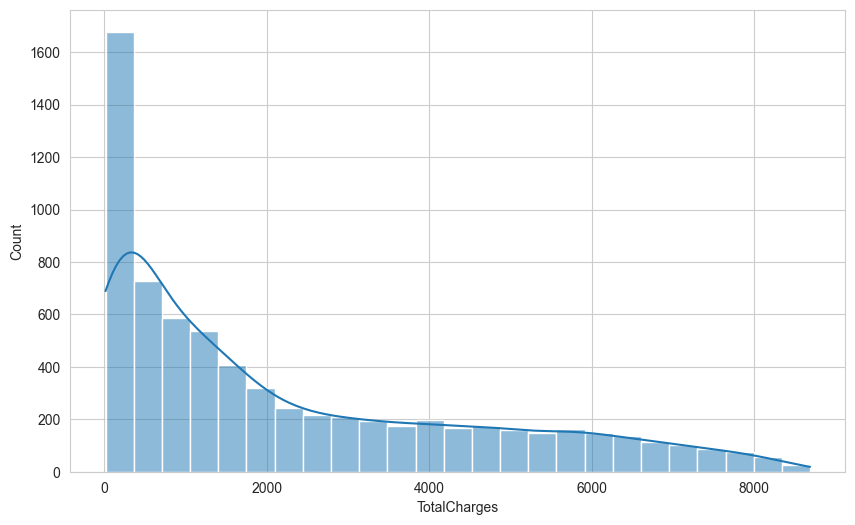

In [6]:
sns.histplot(x=df.TotalCharges , kde=True ) #kde = a line above the graph.

In [7]:
df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())

In [8]:
print("Remaining missing: ",df.TotalCharges.isnull().sum())

Remaining missing:  0


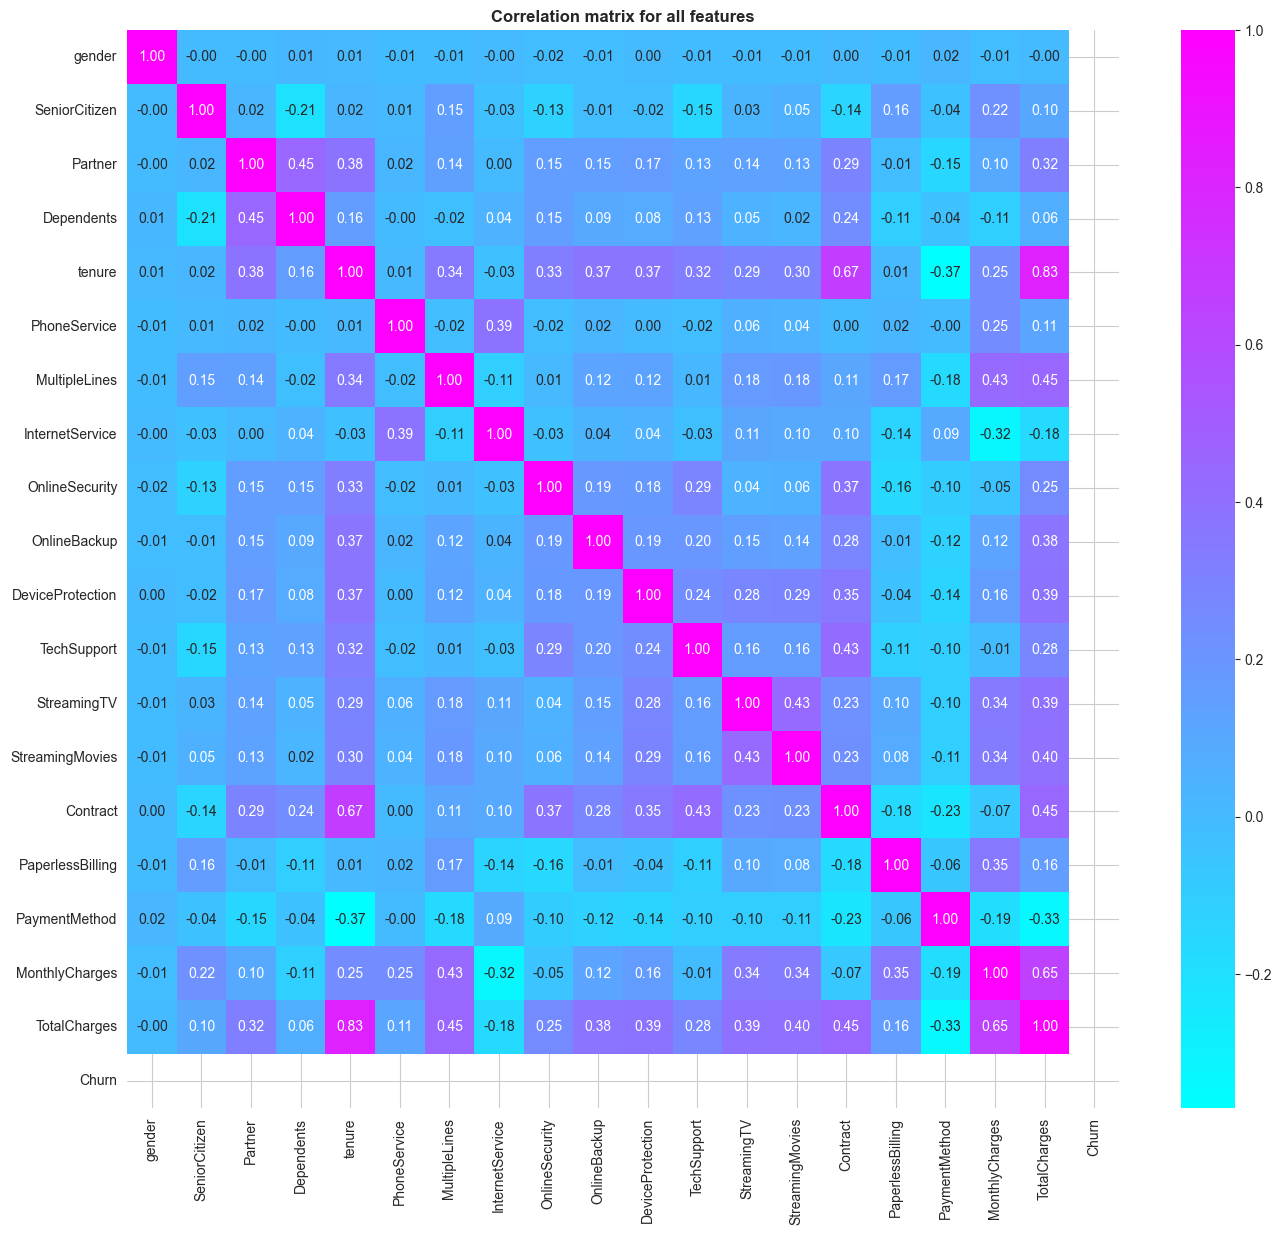

In [9]:
#Correlation Heatmap
#need to convert categorical features into numeric form [temporary encoding]

#create a copy to encode
df_corr = df.copy()

#Label encoding
from sklearn.preprocessing import LabelEncoder
df_corr = df_corr.drop('customerID', axis=1)
#encode target variable
df_corr['Churn'] = df_corr['Churn'].map({'yes':1, 'No':0})
#encode categorical variables
cat_cols = df_corr.select_dtypes(include=['object']).columns
for col in cat_cols:
    le = LabelEncoder()
    df_corr[col] = le.fit_transform(df_corr[col].astype(str))

#correlation matrix
correlation_matrix = df_corr.corr()

#Heatmap
plt.figure(figsize=(16,14))
sns.heatmap(correlation_matrix, annot = True, fmt=".2f", cmap="cool")
plt.title('Correlation matrix for all features', fontweight = 'bold')
plt.show()




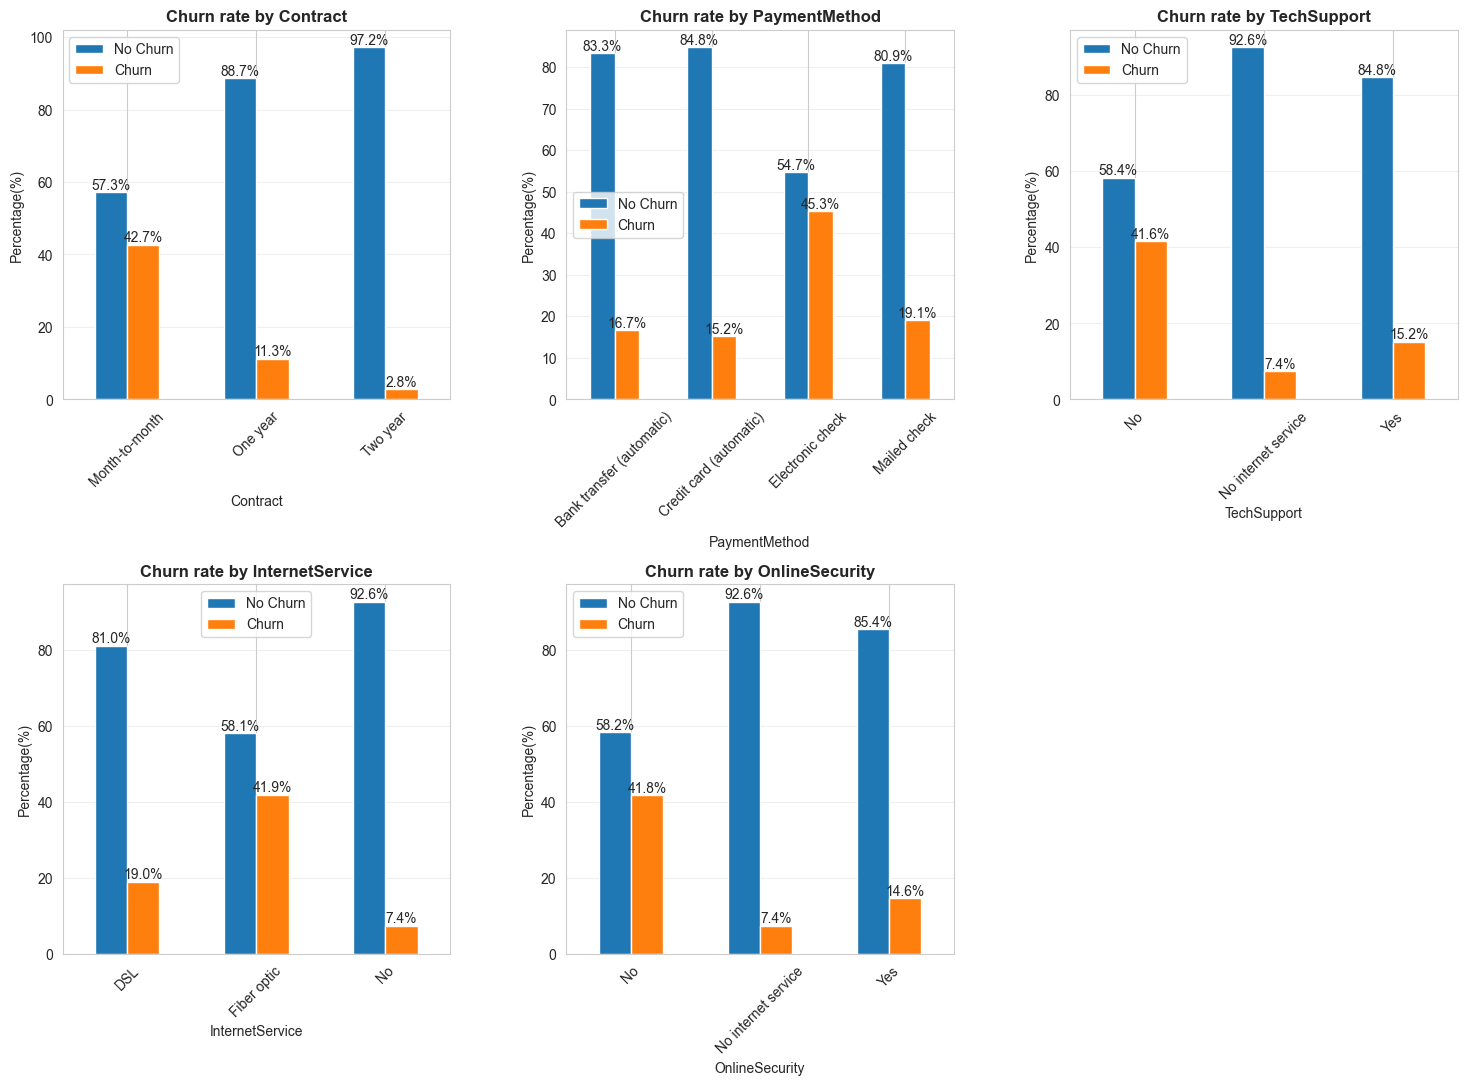

In [10]:
#Key categorical features vs churn
key_features = ['Contract', 'PaymentMethod','TechSupport', 'InternetService', 'OnlineSecurity']

fig, axes = plt.subplots(2,3,figsize=(18,12))
axes = axes.ravel()

for idx, col in enumerate(key_features):
    churn_rate = pd.crosstab(df[col], df['Churn'], normalize='index')*100

    churn_rate.plot(kind='bar', ax=axes[idx])
    axes[idx].set_title(f'Churn rate by {col}',fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Percentage(%)')
    axes[idx].legend(['No Churn','Churn'])
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(axis='y', alpha=0.3)

    #add percentage labels
    for container in axes[idx].containers:
        axes[idx].bar_label(container, fmt='%.1f%%')

    if len(key_features)<6:
        axes[5].set_visible(False)

plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()


<Figure size 1200x600 with 0 Axes>

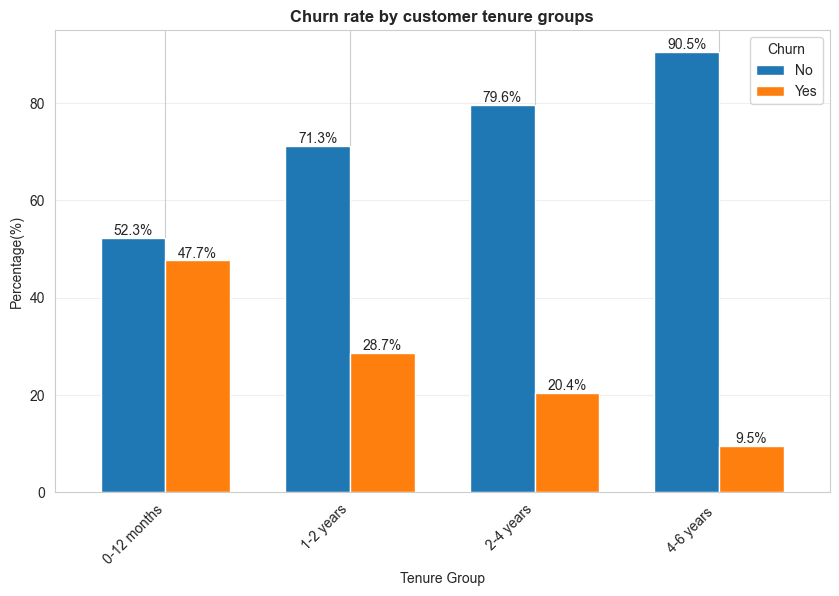

In [11]:
#create tenure groups
df['TenureGroup'] = pd.cut(df['tenure'], bins=[0,12,24,48,72], labels=['0-12 months', '1-2 years', '2-4 years', '4-6 years '])

#churn rate by tenure group
tenure_churn = pd.crosstab(df['TenureGroup'], df['Churn'], normalize= 'index') *100
plt.figure(figsize=(12,6))
tenure_churn.plot(kind='bar', width=0.7)
plt.title('Churn rate by customer tenure groups', fontweight='bold')
plt.xlabel('Tenure Group')
plt.ylabel('Percentage(%)')
plt.legend(title='Churn', labels=['No','Yes'])
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.1f%%')

plt.show()



1. Target variable (Churn) distribution
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Percentages: 
Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


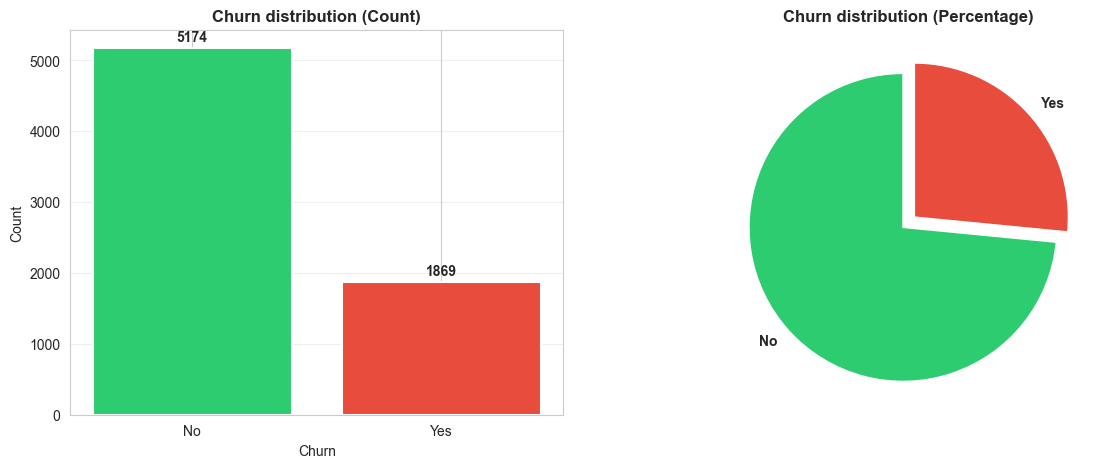

In [12]:
#Univariate analysis

#1. Target (Churn)
print("\n1. Target variable (Churn) distribution")
print("="*60)
churn_counts = df['Churn'].value_counts()
churn_percent = df['Churn'].value_counts(normalize=True)*100
print(churn_counts)
print("\nPercentages: ")
print(churn_percent)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(churn_counts.index, churn_counts.values,color =['#2ecc71', '#e74c3c'], linewidth=1.5)
axes[0].set_title('Churn distribution (Count)', fontweight='bold')
axes[0].set_xlabel('Churn')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y',alpha=0.3)


for i, v in enumerate(churn_counts.values):
    axes[0].text(i, v + 100, str(v), ha='center', fontweight='bold')

#pie chart
colors =['#2ecc71', '#e74c3c']
explode = (0.05, 0.05)
axes[1].pie(churn_counts.values, labels=churn_counts.index, startangle=90, explode=explode,colors=colors, textprops={'fontweight':'bold'})
axes[1].set_title('Churn distribution (Percentage)', fontweight='bold')
plt.show()


2. Numerical features distribution

tenure:
Mean: 32.37
Median: 29.00
Std Dev: 24.56
Min: 0.00, Max: 72.00
Skewness: 0.24
Kurtosis: -1.39

MonthlyCharges:
Mean: 64.76
Median: 70.35
Std Dev: 30.09
Min: 18.25, Max: 118.75
Skewness: -0.22
Kurtosis: -1.26

TotalCharges:
Mean: 2281.92
Median: 1397.47
Std Dev: 2265.27
Min: 18.80, Max: 8684.80
Skewness: 0.96
Kurtosis: -0.23


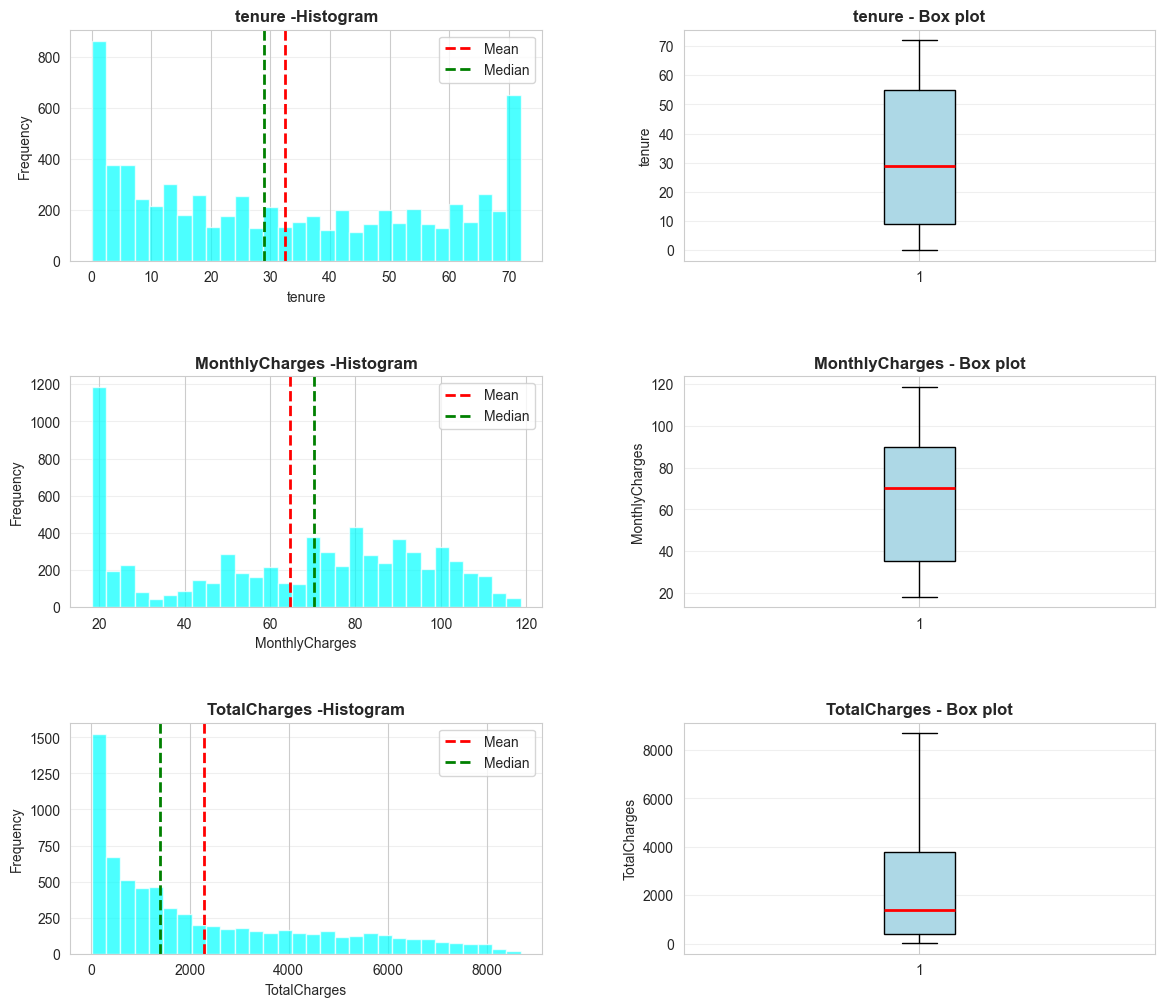

In [13]:
#2. Numerical features analysis
print("\n2. Numerical features distribution")
print("="*60)
fig, axes = plt.subplots(3,2,figsize=(14,12))
num_cols= ['tenure', 'MonthlyCharges', 'TotalCharges']
for idx, col in enumerate(num_cols):
    #histogram
    axes[idx,0].hist(df[col].dropna(), bins=30, color='cyan', alpha=0.7)
    axes[idx,0].set_title(f'{col} -Histogram', fontweight='bold')
    axes[idx,0].set_xlabel(col)
    axes[idx,0].set_ylabel('Frequency')
    axes[idx,0].axvline(df[col].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
    axes[idx,0].axvline(df[col].median(), color='green', linestyle='--', linewidth=2, label='Median')
    axes[idx,0].legend()
    axes[idx,0].grid(axis='y', alpha=0.3)

    #box plots
    axes[idx,1].boxplot(df[col].dropna(), vert=True, patch_artist=True,
                         boxprops=dict(facecolor='lightblue', color='black'),
                         medianprops=dict(color='red', linewidth=2),
                         whiskerprops=dict(color='black'),
                         capprops=dict(color='black'))
    axes[idx,1].set_title(f'{col} - Box plot', fontweight='bold')
    axes[idx,1].set_ylabel(col)
    axes[idx,1].grid(axis='y', alpha=0.3)

    print(f"\n{col}:")
    print(f"Mean: {df[col].mean():.2f}")
    print(f"Median: {df[col].median():.2f}")
    print(f"Std Dev: {df[col].std():.2f}")
    print(f"Min: {df[col].min():.2f}, Max: {df[col].max():.2f}")
    print(f"Skewness: {df[col].skew():.2f}")
    print(f"Kurtosis: {df[col].kurtosis():.2f}")

plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()


3. Categorical feature distribution
Total categorical features: 15

gender:
gender
Male      3555
Female    3488
Name: count, dtype: int64
  Mode: Male

SeniorCitizen:
SeniorCitizen
0    5901
1    1142
Name: count, dtype: int64
  Mode: 0

Partner:
Partner
No     3641
Yes    3402
Name: count, dtype: int64
  Mode: No

Dependents:
Dependents
No     4933
Yes    2110
Name: count, dtype: int64
  Mode: No

Contract:
Contract
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64
  Mode: Month-to-month

InternetService:
InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64
  Mode: Fiber optic

PaymentMethod:
PaymentMethod
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: count, dtype: int64
  Mode: Electronic check


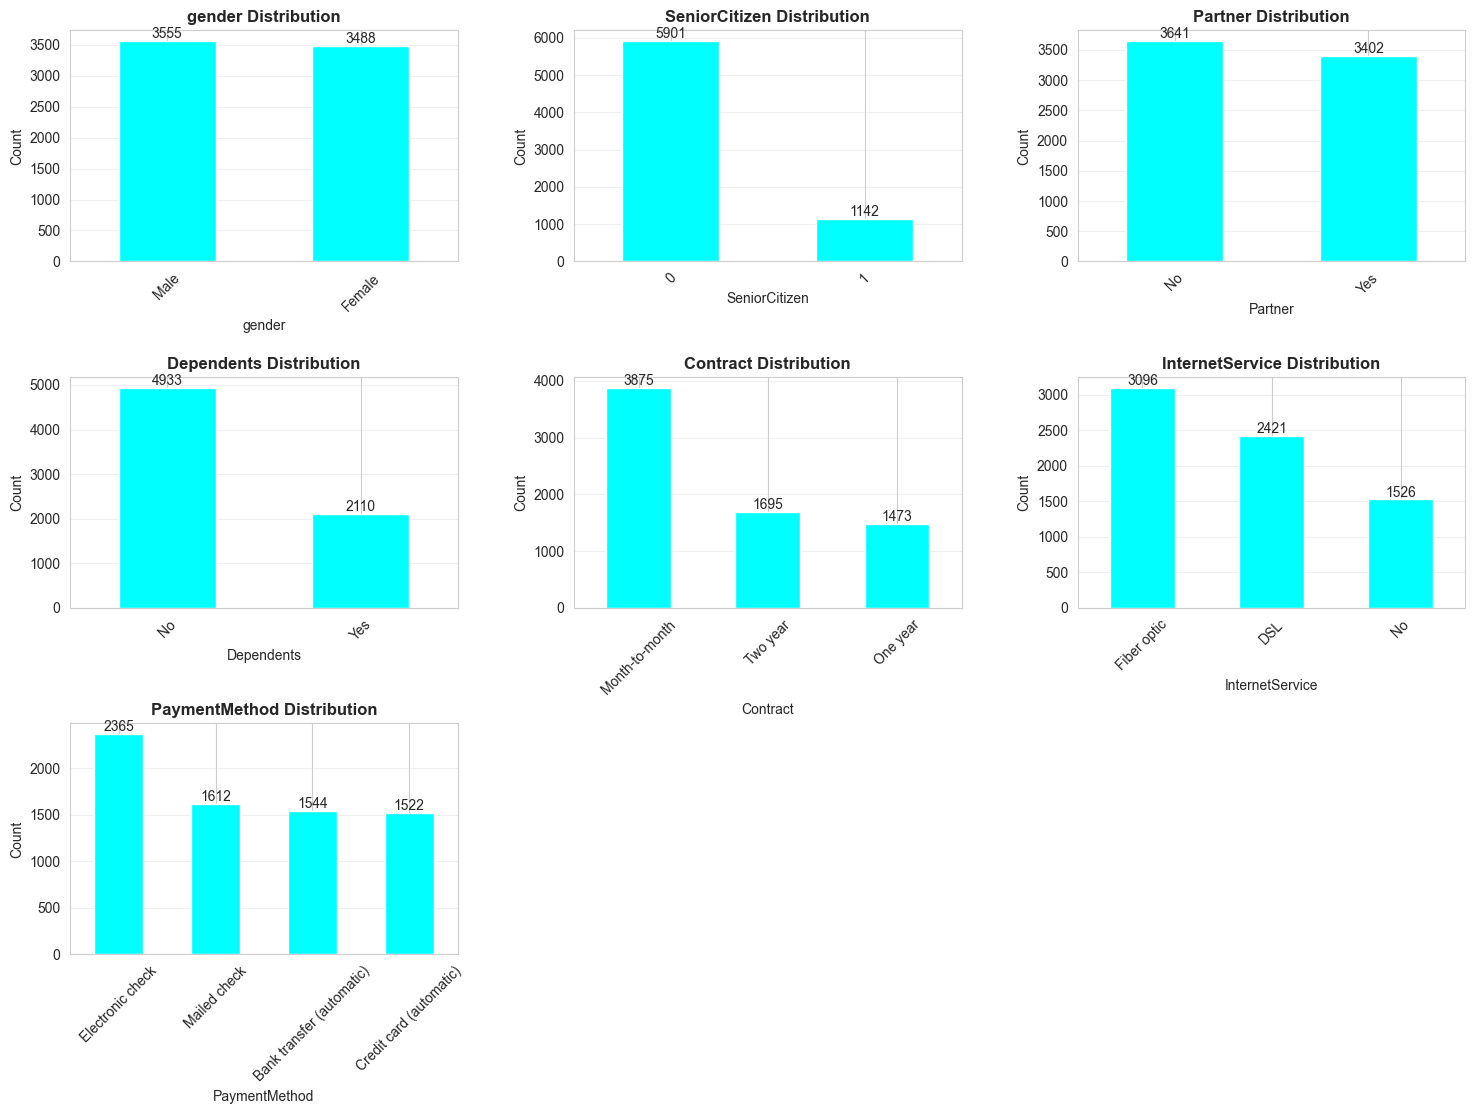

In [14]:
#3.Categorical feature analysis
print("\n3. Categorical feature distribution")
print("="*60)

cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols.remove('customerID')
cat_cols.remove('Churn')

print(f"Total categorical features: {len(cat_cols)}")
#analyze key categorical features

key_cat = ['gender','SeniorCitizen','Partner', 'Dependents', 'Contract', 'InternetService','PaymentMethod']
fig, axes = plt.subplots(3,3,figsize=(18,12))
axes= axes.ravel()

for idx, col in enumerate(key_cat):
    if col == 'SeniorCitizen':
        value_counts= df[col].value_counts()
    else:
        value_counts= df[col].value_counts()

    #count plot
    value_counts.plot(kind='bar', ax=axes[idx], color='cyan')
    axes[idx].set_title(f'{col} Distribution', fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Count')
    axes[idx].tick_params(axis='x',rotation=45)
    axes[idx].grid(axis='y', alpha=0.3)

    for container in axes[idx].containers:
        axes[idx].bar_label(container)

    print(f"\n{col}:")
    print(value_counts)
    print(f"  Mode: {df[col].mode()[0]}")

# Hide unused subplots
for i in range(len(key_cat), 9):
    axes[i].set_visible(False)

plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()


1. Numerical features VS Churn

tenure by Churn:
        count       mean        std  min   25%   50%   75%   max
Churn                                                           
No     5174.0  37.569965  24.113777  0.0  15.0  38.0  61.0  72.0
Yes    1869.0  17.979133  19.531123  1.0   2.0  10.0  29.0  72.0

MonthlyCharges by Churn:
        count       mean        std    min    25%     50%   75%     max
Churn                                                                  
No     5174.0  61.265124  31.092648  18.25  25.10  64.425  88.4  118.75
Yes    1869.0  74.441332  24.666053  18.85  56.15  79.650  94.2  118.35

TotalCharges by Churn:
        count         mean          std    min      25%       50%      75%  \
Churn                                                                        
No     5174.0  2552.882494  2327.590132  18.80  579.575  1679.525  4262.85   
Yes    1869.0  1531.796094  1890.822994  18.85  134.500   703.550  2331.30   

           max  
Churn           
No   

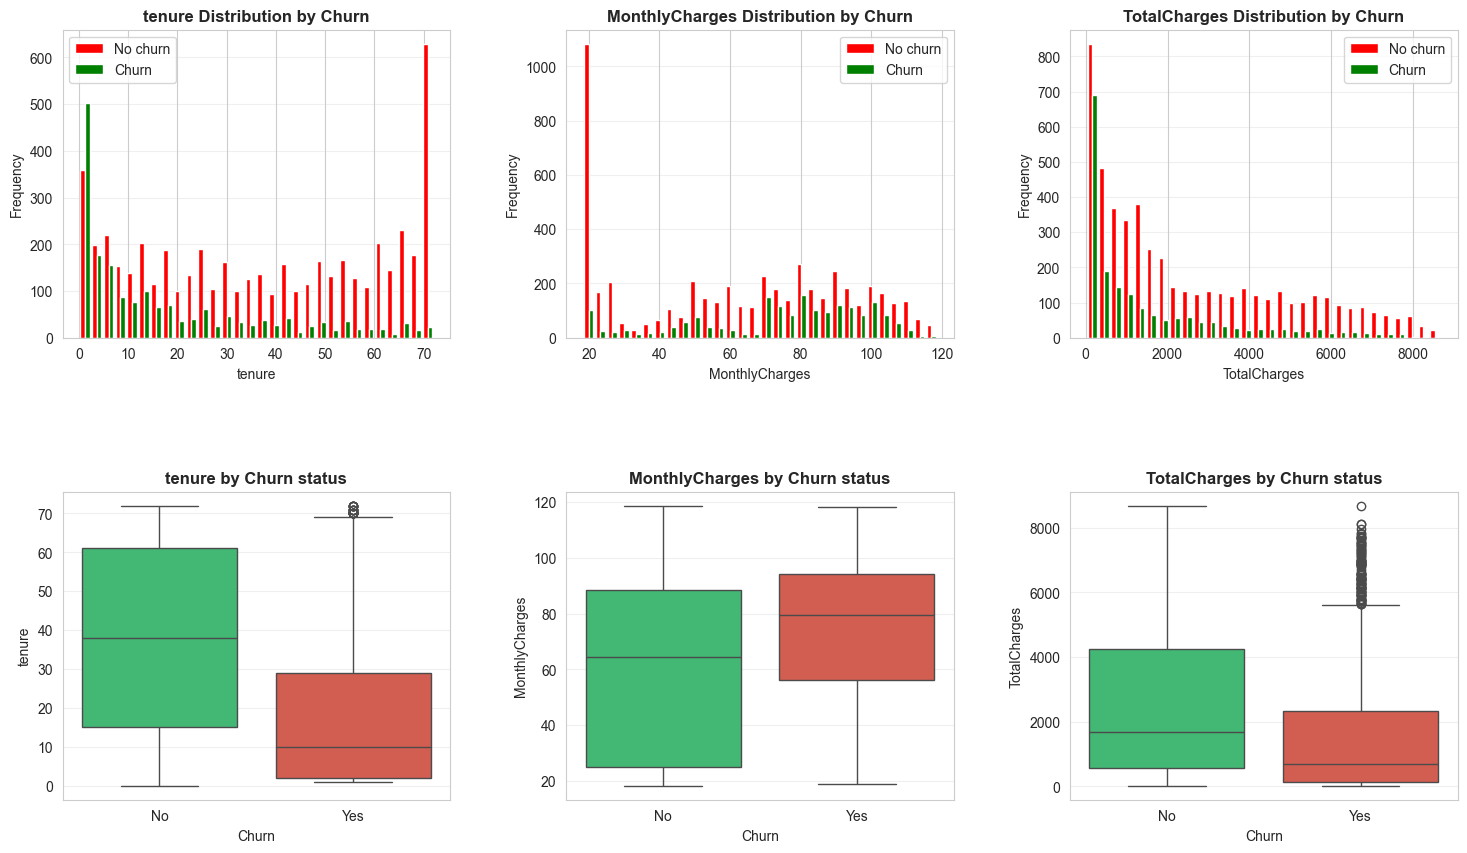

In [15]:
#Bivariate analysis

# 1.Numerical vs Target (Churn)
print("\n1. Numerical features VS Churn")
print("="*60)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
#histograms
for idx, col in enumerate(num_cols):
    axes[0,idx].hist([df[df['Churn']=='No'][col], df[df['Churn']=='Yes'][col]], bins=30, label=['No churn', 'Churn'],color=['Red', 'Green'])
    axes[0,idx].set_title(f'{col} Distribution by Churn', fontweight='bold')
    axes[0,idx].set_xlabel(col)
    axes[0,idx].set_ylabel('Frequency')
    axes[0,idx].legend()
    axes[0,idx].grid(axis='y', alpha=0.3)

#box plots
for idx, col in enumerate(num_cols):
    sns.boxplot(x='Churn', y=col, data=df, ax=axes[1,idx],palette=['#2ecc71', '#e74c3c'])
    axes[1,idx].set_title(f'{col} by Churn status', fontweight='bold')
    axes[1,idx].set_xlabel('Churn')
    axes[1,idx].set_ylabel(col)
    axes[1,idx].grid(axis='y', alpha=0.3)

    print(f"\n{col} by Churn:")
    print(df.groupby('Churn')[col].describe())

plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()


1. Categorical features vs Churn

Contract vs Churn (counts):
Churn             No   Yes
Contract                  
Month-to-month  2220  1655
One year        1307   166
Two year        1647    48

Contract vs Churn (percentages):
Churn                  No        Yes
Contract                            
Month-to-month  57.290323  42.709677
One year        88.730482  11.269518
Two year        97.168142   2.831858

InternetService vs Churn (counts):
Churn              No   Yes
InternetService            
DSL              1962   459
Fiber optic      1799  1297
No               1413   113

InternetService vs Churn (percentages):
Churn                   No        Yes
InternetService                      
DSL              81.040892  18.959108
Fiber optic      58.107235  41.892765
No               92.595020   7.404980

TechSupport vs Churn (counts):
Churn                  No   Yes
TechSupport                    
No                   2027  1446
No internet service  1413   113
Yes             

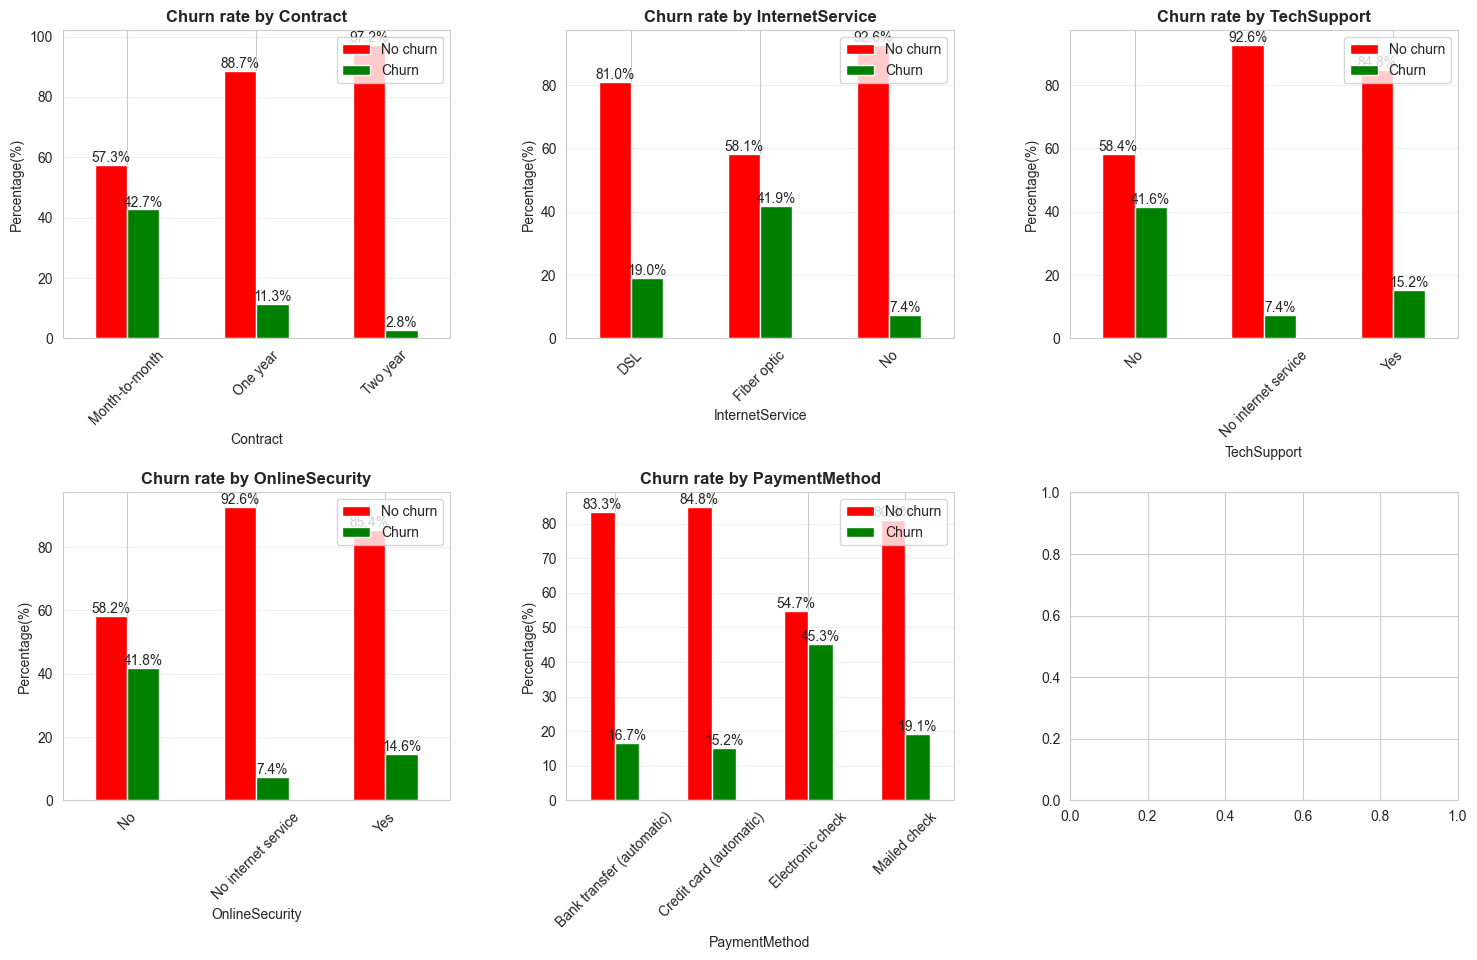

In [16]:
# 2.Categorical Variables vs Churn
print("\n1. Categorical features vs Churn")
print("="*60)

key_categorical = ['Contract','InternetService','TechSupport','OnlineSecurity','PaymentMethod']

fig, axes = plt.subplots(2,3,figsize=(18,10))
axes= axes.ravel()

for idx, col in enumerate(key_categorical):
    #calculate churn rate
    churn_rate = pd.crosstab(df[col], df['Churn'], normalize='index')*100

    #stacked barchart
    churn_rate.plot(kind='bar', ax=axes[idx], stacked=False, linewidth=1, color=['Red','Green'])
    axes[idx].set_title(f'Churn rate by {col}', fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Percentage(%)')
    axes[idx].legend(['No churn', 'Churn'], loc='upper right')
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(axis='y', alpha=0.3)

    for container in axes[idx].containers:
        axes[idx].bar_label(container, fmt='%.1f%%',)

    print(f"\n{col} vs Churn (counts):")
    print(pd.crosstab(df[col], df['Churn']))
    print(f"\n{col} vs Churn (percentages):")
    print(churn_rate)

plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

